In [5]:
import os
  
print(os.cpu_count())

32


In [26]:
import platform,socket,re,uuid,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return info
    except Exception as e:
        logging.exception(e)

print(*getSystemInfo().values(), sep="\n")

Linux
4.9.0-18-amd64
#1 SMP Debian 4.9.303-1 (2022-03-07)
x86_64
4dc96526adf1
172.17.0.19
99:04:97:4b:1b:94
x86_64
126 GB


In [2]:
import numpy as np

class Perlin2D():
    
    #Shape : [sx,sy] où sx et sy sont la taille de la matrice
    #Res : [rx,ry] où sx est multiple de rx, et rx = la résolution/fréquence primaire sur x,
            #c'est à dire si rx augmente alors on calcule une plus grande zone de notre bruit (même idée sur y)
    def __init__(self,shape,res):
        self.shape = shape
        self.res = res
        #Matrice aléatoire qui donne le côté aléatoire au bruit vu qu'elle sera différente pour tous les instances
            #de l'objet perlin2D.
        self.random_numpy = np.random.rand(res[0]+1, res[1]+1)
        
        self.noise = self.perlin2D()
        
    def lerp(self, t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    def regenRdmNoise(self):
        self.random_numpy = np.random.rand(int(self.res[0])+1, int(self.res[1])+1)
    
    #Gen le bruit de Perlin en 2D
    def perlin2D(self):
        shape = self.shape
        res = self.res
        lerp = self.lerp

        #basé sur https://weber.itn.liu.se/~stegu/simplexnoise/simplexnoise.pdf ; https://fr.wikipedia.org/wiki/Bruit_de_Perlin
        delta = (res[0] / shape[0], res[1] / shape[1])
        d = (shape[0] // res[0], shape[1] // res[1])
        
        #On définit la grille sur laquelle on va travailler, en effet res<shape donc on créer les coordonnées dans les 
        #dans les intervalles entre les points de la matrice aléatoire(de taille res).
        grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
        
        #Le bruit de Perlin est basé sur l'utilisation des gradients et tout son intérêt provient de cette opératon
        #appliquée sur la matrice aléatoire
        random_numpy = self.random_numpy
        angles = 2*np.pi*random_numpy[0:res[0]+1, 0:res[1]+1]
        gradients = np.dstack((np.cos(angles), np.sin(angles)))
        g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
        g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
        g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
        g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
        
        #Par la suite on l'applique à la grille en faisant des produits scalaires/rampes.
        n00 = np.sum(grid * g00, 2)
        n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
        n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
        n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
        
        #On applique un procédé d'interpolation sur la grille (procédé défini dans le doc de Perlin)
        t = lerp(grid)
        n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
        n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
        
        #On normalise le bruit pour qu'il soit entre 0 et 1(pour faciliter la manipulation)
        return (np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1) + 1)/2
    
    #Gen le bruit fractal
    def fractal2D(self, octaves=1, persistance=0.5, exponentiation=1, lacunarity=1, norm=True):
        shape = self.shape
        res = self.res
        noise = np.zeros([int(shape[0]),int(shape[1])])
        
        frequency = 1
        amplitude = 1
        
        #Comparable à une série de Fourier, on ajoute plusieurs octaves/bruits avec une fréquence et amplitude
            #multipliées pour chaque itération de la série. = On rajoute du "détail" au bruit
        for _ in range(octaves):
            res = [frequency * res[0], frequency * res[1]]
            self.res = res
            self.regenRdmNoise()
            noise += amplitude * self.perlin2D()
            frequency *= lacunarity
            amplitude *= persistance
        
        noise = noise**exponentiation
        
        #On normalise pour être certain qu'il soit entre 0 et 1
        return noise/noise.max() if(norm) else noise
    

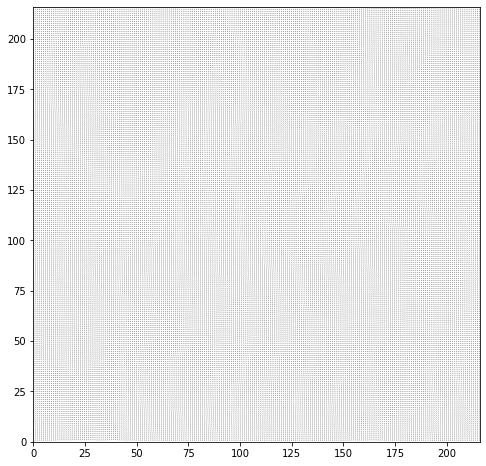

7464.960000000001


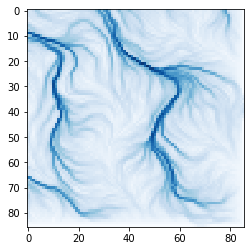

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import math
from multiprocessing import RawArray

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

NUM_PROC = 32

shape = 3*6*12
delta = 1.0

noise = Perlin2D([shape,shape],[3,3]).fractal2D(3, 0.5, 1, 2)
field = []
for i in range(len(noise)):
    for j in range(len(noise[i])):
        field.append((np.cos(noise[i][j] * (2*np.pi)),np.sin(noise[i][j] * (2*np.pi))))
field = np.asarray(field)

X,Y = np.mgrid[delta:shape+delta:delta, delta:shape+delta:delta]
U=np.array([field[i][0] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))
V=np.array([field[i][1] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))

fig, ax = plt.subplots(figsize=(8,8))

ax.axis([0, shape, 0, shape])

q = ax.quiver(X, Y, U, V)
plt.show()

class Particle2D():
    #plot : [X,Y,U,V]
    def __init__(self,shape, res, mass, pos, plot, friction=0.5):
        
        self.M = np.zeros((int(shape/res),int(shape/res))) 
        
        self.iteration = 0
        self.pos = pos
        self.mass = mass
        self.plot = plot
        self.friction = friction
        self.v = np.asarray([0,0])
        
        self.shape = shape
        self.res = res
        
    def simulate(self,index, return_dict, time, dt, incr):
        for t in range(int(time/dt)):
            flag, self.M = self.update(self.M,incr,dt,t,time)
            if(flag):
                return_dict[index] = self.M
                return self.M
        
        return_dict[index] = self.M
        return self.M
        
        
    def update(self,M,incr,dt,t,time):      
        M[int(self.pos[1] * len(M) / shape)][int(self.pos[0] * len(M[0]) / shape)] += incr
        
        self.pos += self.v * dt
        
        if(self.pos[0] > shape or self.pos[0] < 0 or self.pos[1] > shape or self.pos[1] < 0):
            return (True, M)
        
        self.v = np.asarray((self.v[0] *self.friction,self.v[1] *self.friction))
        vec = self.getClosestVector()
        self.v = np.asarray([(1/self.mass) * vec[0],(1/self.mass) * vec[1]])
        return (False, M)
    
    def getClosestVector(self):
        X,Y,U,V,X2,Y2 = self.plot
        mini = [X.max(),Y.max()]
        vec = (0,0)
        for i in range(len(X)):
            for j in range(len(Y)):
                x = X[i][0]
                y = Y[0][j]
                if(np.abs(x-self.pos[0]) <= mini[0] and np.abs(y-self.pos[1]) <= mini[1]):
                    mini[0] = np.abs(x-self.pos[0])
                    mini[1] = np.abs(y-self.pos[1])
                    vec = (U[j][i],V[j][i])
        return vec
    def getAbsoluteVecPos(self,vec,U,V):
        for i in range(len(U)):
            for j in range(len(V)):
                if(U[j][i] == vec[0] and V[j][i] == vec[1]):
                    return (i*delta,j*delta)
    
    

class SimulationPlot():
    def __init__(self,res,shape,X,Y,U,V):
        
        self.M = np.zeros((int(shape/res),int(shape/res)))
        
        self.shape = shape
        self.res = res
        
        self.particles = []
        X2,Y2 = np.mgrid[res:shape+res:res, res:shape+res:res]
        
        for i in range(int(shape/res)):
            for j in range(int(shape/res)):
                self.particles.append(Particle2D(shape,res,1,np.array([i*res,j*res]),(X,Y,U,V,X2,Y2)))
                
    def Simulate(self, border, time, dt, incr):
        
        manager = multiprocessing.Manager()
        
        for i in range(math.ceil(len(self.particles) / NUM_PROC)):
            
            DATA = manager.dict()
            
            jobs = []
            for k in range(NUM_PROC):
                if(i * NUM_PROC + k < len(self.particles)):
                    process = multiprocessing.Process(
                        target=self.particles[i*NUM_PROC+k].simulate, 
                        args=(i * NUM_PROC + k,DATA,time,dt,incr)
                    )
                    jobs.append(process)
            for j in jobs:
                j.start()

            for j in jobs:
                j.join()
            
            printProgressBar(i, math.ceil(len(self.particles) / NUM_PROC), prefix = 'Progress:', suffix = 'Complete', length = 50)
            for m in DATA.values():
                self.M = self.M + m
                

        return np.array(list(map(lambda i: list(map(lambda j: j if j <= border else border ,i)),np.log(self.M+1)/self.M.max())))
    
delta = 2.5

print("{}".format((shape/delta)**2))

s = SimulationPlot(delta,shape,X,Y,U,V)
result = s.Simulate(0.1,100,0.5, 0.025)
plt.imshow(result, cmap="Blues", interpolation='None')
plt.show()


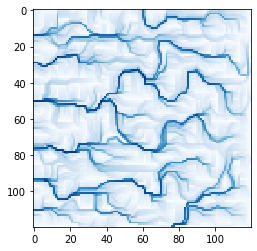

In [4]:
plt.imshow(result, cmap="Blues", interpolation='None') 

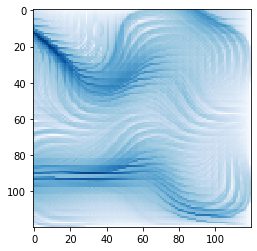

In [4]:
plt.imshow(result, cmap="Blues", interpolation='None')